In [74]:
from keras import backend as K

In [75]:
import numpy as np
import pandas as pd

In [76]:
import keras

# Indodax Data Retrieval

In [77]:
import requests
import datetime
import pytz
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

## Training Data

In [78]:
root_uri_trade_api = 'https://indodax.com/api'
root_uri_chart_api = 'https://indodax.com/tradingview/history'
#?symbol=BTCIDR&resolution=15&from=1546489788&to=1547785848'
chart_currency = 'BTCIDR'
period = '5'
time_begin = int(datetime.datetime(2015, 11, 1).timestamp())
time_end = int(datetime.datetime(2016, 5, 1).timestamp())
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)
training_frame = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
# }, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)).strftime('%d/%m %H.%M'), r.json()['t'])))
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
len(training_frame)

52417

In [79]:
training_frame.head()

,open,close,high,low,volume
2015-11-01 00:00:00,4610000,4606900,4610000,4606900,2.016935
2015-11-01 00:05:00,4606900,4606900,4606900,4606800,4.587916
2015-11-01 00:10:00,4606900,4606900,4606900,4606800,0.744958
2015-11-01 00:15:00,4606900,4595000,4606900,4595000,14.910502
2015-11-01 00:20:00,4595000,4582000,4606700,4581900,5.650364


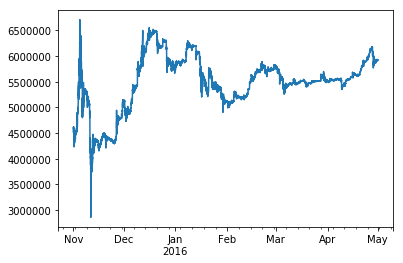

In [80]:
training_frame['close'].plot()

## Testing Data
### Ascending Price

In [81]:
time_begin = int(datetime.datetime(2017, 10, 1).timestamp())
time_end = int(datetime.datetime(2017, 12, 1).timestamp())
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)
asc_test_frame = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
len(asc_test_frame)

17569

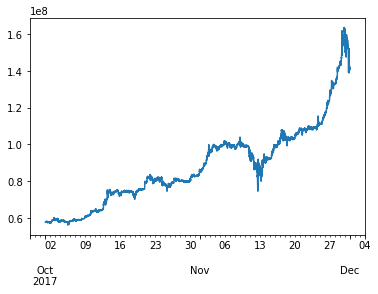

In [82]:
asc_test_frame['close'].plot()

### Descending Test Price

In [83]:
time_begin = int(datetime.datetime(2018, 1, 1).timestamp())
time_end = int(datetime.datetime(2018, 3, 1).timestamp())
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)
desc_test_frame = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
len(desc_test_frame)

16993

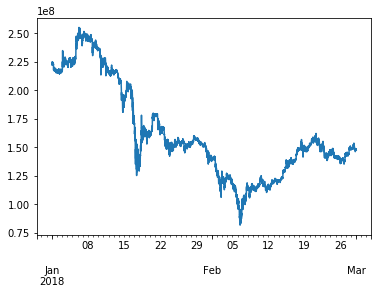

In [84]:
desc_test_frame['close'].plot()

### Stagnant Test Price

In [85]:
time_begin = int(datetime.datetime(2016, 8, 10).timestamp())
time_end = int(datetime.datetime(2016, 10, 10).timestamp())
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)
stag_test_frame = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
len(stag_test_frame)

17569

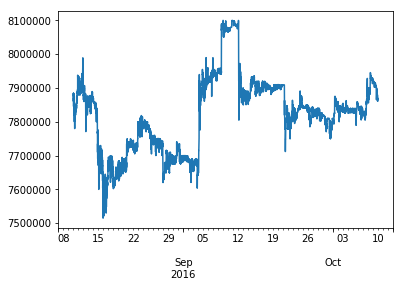

In [86]:
stag_test_frame['close'].plot()

# Calculate Profit Using Test Strategy

In [91]:
import backtrader as bt
import backtrader.feeds as btfeeds
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # weird workaround due to limitation to column name
        # we take the low column as action
        self.data_action = self.datas[0].low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.opsize = order.executed.size
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                gross_pnl = (order.executed.price - self.buyprice) * \
                    self.opsize

                net_pnl = gross_pnl - self.buycomm - order.executed.comm
                self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                         (gross_pnl, net_pnl))


            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy!
            if self.data_action[0] == -1:
                self.log('BUY CREATE')
                self.order = self.buy()

        else:
            # sell!
            if self.data_action[0] == 1:
                self.log('SELL CREATE')
                self.order = self.sell()

In [92]:
def run_calculate_profit(action_frame, label):
    commission = 0.003
    action_frame['low'] = label
    data_feed = btfeeds.PandasData(dataname=action_frame, openinterest=None)

    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)
    cerebro.adddata(data_feed)
    # cerebro.adddata(action_frame)
    cerebro.broker.setcash(100000000.0)
    cerebro.broker.setcommission(commission=commission)

    # Print out the starting conditions
    startingPortofolio = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    finalPortofolio = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

# Data Processing

In [96]:
t_backward = 3
regr_count = 1

tmp_data_frame = []
for i in range(t_backward, len(training_frame)-regr_count):
    to_append = training_frame['close'][i-t_backward:i+regr_count]
    tmp_data_frame.append(to_append)
training_frame_ext = tmp_data_frame

tmp_data_frame = []
for i in range(t_backward, len(asc_test_frame)-regr_count):
    to_append = asc_test_frame['close'][i-t_backward:i+regr_count]
    tmp_data_frame.append(to_append)
asc_test_frame_ext = tmp_data_frame

tmp_data_frame = []
for i in range(t_backward, len(desc_test_frame)-regr_count):
    to_append = desc_test_frame['close'][i-t_backward:i+regr_count]
    tmp_data_frame.append(to_append)
desc_test_frame_ext = tmp_data_frame

tmp_data_frame = []
for i in range(t_backward, len(stag_test_frame)-regr_count):
    to_append = stag_test_frame['close'][i-t_backward:i+regr_count]
    tmp_data_frame.append(to_append)
stag_test_frame_ext = tmp_data_frame

columns = []
now = -t_backward+1
for i in range(t_backward+regr_count):
    if now != 0:
        columns.append('t'+str(now))
    else:
        columns.append('t')
    now += 1

training_frame_ext = pd.DataFrame(np.array(training_frame_ext), columns=columns)
asc_test_frame_ext = pd.DataFrame(np.array(asc_test_frame_ext), columns=columns)
desc_test_frame_ext = pd.DataFrame(np.array(desc_test_frame_ext), columns=columns)
stag_test_frame_ext = pd.DataFrame(np.array(stag_test_frame_ext), columns=columns)

# Linear Regression
## Training Phase
### Feature Extraction

In [97]:
feature_cols = columns[:t_backward]
label_columns = columns[-regr_count:]

x_training_frame = training_frame_ext[feature_cols]
y_training_frame = training_frame_ext[label_columns]

x_asc_test_frame = asc_test_frame_ext[feature_cols]
y_asc_test_frame = asc_test_frame_ext[label_columns]

x_desc_test_frame = desc_test_frame_ext[feature_cols]
y_desc_test_frame = desc_test_frame_ext[label_columns]

x_stag_test_frame = stag_test_frame_ext[feature_cols]
y_stag_test_frame = stag_test_frame_ext[label_columns]

In [98]:
from sklearn.linear_model import LinearRegression

regs = [LinearRegression() for i in range(regr_count)]
for i in range(len(regs)):
    reg = regs[i]
    reg.fit(x_training_frame, y_training_frame[label_columns[i]])
    print('Score of the-', i+1,' regression: ')
    print('    Ascending : ',reg.score(x_asc_test_frame, y_asc_test_frame[label_columns[i]]))
    print('    Descending : ',reg.score(x_desc_test_frame, y_desc_test_frame[label_columns[i]]))
    print('    Stagnant : ',reg.score(x_stag_test_frame, y_stag_test_frame[label_columns[i]]))

Score of the- 1  regression: 
    Ascending :  0.9997784101686312
    Descending :  0.9996811504160016
    Stagnant :  0.9945564023019827


## Testing Phase
### Labelling Testing Data

In [99]:
from statistics import mean
from time import time

def get_index_based_mean(lst):
    ans = 0
    multiplier = 1
    for i in range(len(lst)):
        if (i != len(lst)-1):
            multiplier /= 2
        ans += lst[i]*multiplier
    return ans

def label_test_data(x_test, y_test):
    label = []
    start_time = time()

    for i in range(len(x_test)):
        feat = x_test[i:i+1]

        feature_ext = []
        for j in feature_cols:
            now = feat[j]
            for tmp in now:
                feature_ext.append(tmp)

        predict = [regs[i].predict(feat)[0] for i in range(regr_count)]

        prev_price = feature_ext[-1]
        predict_mean = get_index_based_mean(predict)
        predict_mean_commision = 0.003*predict_mean

        mean_delta = predict_mean - prev_price
        if mean_delta > 0:
            if mean_delta > predict_mean_commision:
                label.append(-1)
            else:
                label.append(0)
        else:
            if mean_delta < -predict_mean_commision:
                label.append(1)
            else:
                label.append(0)
    
    end_time = time()
    print('Elapsed Time:',end_time-start_time,'second(s)')
    print('Label statistic:')
    print('    Buy', len(list(filter(lambda p: p == -1, label))))
    print('    Hold', len(list(filter(lambda p: p == 0, label))))
    print('    Sell', len(list(filter(lambda p: p == 1, label))))
    return label

### Ascending Data

In [100]:
asc_test_label = label_test_data(x_asc_test_frame, y_asc_test_frame)

Elapsed Time: 11.657761096954346 second(s)
Label statistic:
    Buy 30
    Hold 17497
    Sell 38


In [101]:
run_calculate_profit(asc_test_frame[t_backward:-regr_count], asc_test_label)

Starting Portfolio Value: 100000000.00


/home/sangbijaksana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2017-10-13, BUY CREATE
2017-10-13, BUY EXECUTED, Price: 71005200.00, Cost: 71005200.00, Comm 213015.60
2017-10-13, SELL CREATE
2017-10-13, SELL EXECUTED, Price: 73800100.00, Cost: 71005200.00, Comm 221400.30
2017-10-13, OPERATION PROFIT, GROSS 2794900.00, NET 2360484.10
2017-11-02, BUY CREATE
2017-11-02, BUY EXECUTED, Price: 97497900.00, Cost: 97497900.00, Comm 292493.70
2017-11-02, SELL CREATE
2017-11-02, SELL EXECUTED, Price: 95999500.00, Cost: 97497900.00, Comm 287998.50
2017-11-02, OPERATION PROFIT, GROSS -1498400.00, NET -2078892.20
2017-11-11, BUY CREATE
2017-11-11, BUY EXECUTED, Price: 92945000.00, Cost: 92945000.00, Comm 278835.00
2017-11-11, SELL CREATE
2017-11-11, SELL EXECUTED, Price: 88660000.00, Cost: 92945000.00, Comm 265980.00
2017-11-11, OPERATION PROFIT, GROSS -4285000.00, NET -4829815.00
2017-11-12, BUY CREATE
2017-11-12, BUY EXECUTED, Price: 76630100.00, Cost: 76630100.00, Comm 229890.30
2017-11-12, SELL CREATE
2017-11-12, SELL EXECUTED, Price: 83823100.00, Cost: 766

### Descending Data

In [102]:
desc_test_label = label_test_data(x_desc_test_frame, y_desc_test_frame)

Elapsed Time: 11.931921482086182 second(s)
Label statistic:
    Buy 43
    Hold 16823
    Sell 123


In [103]:
run_calculate_profit(desc_test_frame[t_backward:-regr_count], desc_test_label)

Starting Portfolio Value: 100000000.00


/home/sangbijaksana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2018-01-10, BUY CREATE
2018-01-10, Order Canceled/Margin/Rejected
2018-01-10, BUY CREATE
2018-01-10, Order Canceled/Margin/Rejected
2018-01-14, BUY CREATE
2018-01-14, Order Canceled/Margin/Rejected
2018-01-14, BUY CREATE
2018-01-14, Order Canceled/Margin/Rejected
2018-01-16, BUY CREATE
2018-01-16, Order Canceled/Margin/Rejected
2018-01-16, BUY CREATE
2018-01-16, Order Canceled/Margin/Rejected
2018-01-16, BUY CREATE
2018-01-16, Order Canceled/Margin/Rejected
2018-01-16, BUY CREATE
2018-01-16, Order Canceled/Margin/Rejected
2018-01-16, BUY CREATE
2018-01-16, Order Canceled/Margin/Rejected
2018-01-16, BUY CREATE
2018-01-16, Order Canceled/Margin/Rejected
2018-01-17, BUY CREATE
2018-01-17, Order Canceled/Margin/Rejected
2018-01-17, BUY CREATE
2018-01-17, Order Canceled/Margin/Rejected
2018-01-17, BUY CREATE
2018-01-17, Order Canceled/Margin/Rejected
2018-01-17, BUY CREATE
2018-01-17, Order Canceled/Margin/Rejected
2018-01-17, BUY CREATE
2018-01-17, Order Canceled/Margin/Rejected
2018-01-17

### Stagnant Data

In [104]:
stag_test_label = label_test_data(x_stag_test_frame, y_stag_test_frame)

Elapsed Time: 10.99504828453064 second(s)
Label statistic:
    Buy 0
    Hold 17565
    Sell 0


In [105]:
run_calculate_profit(stag_test_frame[t_backward:-regr_count], stag_test_label)

Starting Portfolio Value: 100000000.00


/home/sangbijaksana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Final Portfolio Value: 100000000.00
Profit: 0.00 (0.000000%)


### Training Data

In [106]:
training_test_label = label_test_data(x_training_frame, y_training_frame)

Elapsed Time: 31.954103469848633 second(s)
Label statistic:
    Buy 83
    Hold 52262
    Sell 68


In [107]:
run_calculate_profit(training_frame[t_backward:-regr_count], training_test_label)

Starting Portfolio Value: 100000000.00


/home/sangbijaksana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2015-11-01, BUY CREATE
2015-11-01, BUY EXECUTED, Price: 4620000.00, Cost: 4620000.00, Comm 13860.00
2015-11-03, SELL CREATE
2015-11-03, SELL EXECUTED, Price: 4800000.00, Cost: 4620000.00, Comm 14400.00
2015-11-03, OPERATION PROFIT, GROSS 180000.00, NET 151740.00
2015-11-03, BUY CREATE
2015-11-03, BUY EXECUTED, Price: 4720300.00, Cost: 4720300.00, Comm 14160.90
2015-11-04, SELL CREATE
2015-11-04, SELL EXECUTED, Price: 5288500.00, Cost: 4720300.00, Comm 15865.50
2015-11-04, OPERATION PROFIT, GROSS 568200.00, NET 538173.60
2015-11-04, BUY CREATE
2015-11-04, BUY EXECUTED, Price: 5860000.00, Cost: 5860000.00, Comm 17580.00
2015-11-04, SELL CREATE
2015-11-04, SELL EXECUTED, Price: 5847900.00, Cost: 5860000.00, Comm 17543.70
2015-11-04, OPERATION PROFIT, GROSS -12100.00, NET -47223.70
2015-11-04, BUY CREATE
2015-11-04, BUY EXECUTED, Price: 6443500.00, Cost: 6443500.00, Comm 19330.50
2015-11-04, SELL CREATE
2015-11-04, SELL EXECUTED, Price: 6548000.00, Cost: 6443500.00, Comm 19644.00
2015-11-0

2015-12-12, BUY CREATE
2015-12-12, BUY EXECUTED, Price: 6231100.00, Cost: 6231100.00, Comm 18693.30
2015-12-12, SELL CREATE
2015-12-12, SELL EXECUTED, Price: 6100000.00, Cost: 6231100.00, Comm 18300.00
2015-12-12, OPERATION PROFIT, GROSS -131100.00, NET -168093.30
2015-12-12, BUY CREATE
2015-12-12, BUY EXECUTED, Price: 6033900.00, Cost: 6033900.00, Comm 18101.70
2015-12-12, SELL CREATE
2015-12-12, SELL EXECUTED, Price: 6101000.00, Cost: 6033900.00, Comm 18303.00
2015-12-12, OPERATION PROFIT, GROSS 67100.00, NET 30695.30
2015-12-21, BUY CREATE
2015-12-21, BUY EXECUTED, Price: 6111000.00, Cost: 6111000.00, Comm 18333.00
2016-01-16, SELL CREATE
2016-01-16, SELL EXECUTED, Price: 5600100.00, Cost: 6111000.00, Comm 16800.30
2016-01-16, OPERATION PROFIT, GROSS -510900.00, NET -546033.30
2016-01-16, BUY CREATE
2016-01-16, BUY EXECUTED, Price: 5551300.00, Cost: 5551300.00, Comm 16653.90
2016-01-16, SELL CREATE
2016-01-16, SELL EXECUTED, Price: 5595100.00, Cost: 5551300.00, Comm 16785.30
2016-01